In [23]:
import tweepy
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from wordcloud import WordCloud
from pymongo import MongoClient
import csv


# Help Functions

In [24]:

def get_keys_csv(dir:str):
    """Get all twitter keys from csv

    Args:
        dir(str): Path of csv file 

    Returns:
        _type_: Dictionary
    """
    with open(dir, 'r', encoding = 'utf8') as file:
        reader = csv.reader(file)
        data = list(reader)
        file.close()
    keys = {}
    for k, v in data :
        keys[k] = v
    return keys


# Creating connection to Twitter API

In [25]:
# Load keys from csv
keys = get_keys_csv('C:/Users/Diego/OneDrive/Cursos e codigos/Codigos/twitter/word_cloud/twitter_keys.csv')

# Authentication in twitter api
auth = tweepy.OAuthHandler(keys['consumer_key'], keys['consumer_secret'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth)


# Load tweets and insert then inside MongoDB Collections

In [26]:
# GeoPlanet identifier for searching trends in Brazil
BRAZIL_WOE_ID = 23424768

# Loading trend topics
brazil_trends = api.get_place_trends(BRAZIL_WOE_ID)

In [27]:
# Using JSON parser reads for load tweets 
trends = json.loads(json.dumps(brazil_trends, indent=1))

print(trends)

[{'trends': [{'name': '#UmLugarAoSol', 'url': 'http://twitter.com/search?q=%23UmLugarAoSol', 'promoted_content': None, 'query': '%23UmLugarAoSol', 'tweet_volume': 12109}, {'name': 'Ravi', 'url': 'http://twitter.com/search?q=Ravi', 'promoted_content': None, 'query': 'Ravi', 'tweet_volume': 27455}, {'name': '#RodaViva', 'url': 'http://twitter.com/search?q=%23RodaViva', 'promoted_content': None, 'query': '%23RodaViva', 'tweet_volume': None}, {'name': 'Botafogo', 'url': 'http://twitter.com/search?q=Botafogo', 'promoted_content': None, 'query': 'Botafogo', 'tweet_volume': 52381}, {'name': 'playboi carti', 'url': 'http://twitter.com/search?q=%22playboi+carti%22', 'promoted_content': None, 'query': '%22playboi+carti%22', 'tweet_volume': None}, {'name': 'Ganso', 'url': 'http://twitter.com/search?q=Ganso', 'promoted_content': None, 'query': 'Ganso', 'tweet_volume': None}, {'name': 'Rebeca', 'url': 'http://twitter.com/search?q=Rebeca', 'promoted_content': None, 'query': 'Rebeca', 'tweet_volume':

In [28]:
# Connecting with MongoDB and creating DataBase
client = MongoClient('localhost', 27017)
db = client.trends_twitter

# Creating a MongoDB collection
colection = db.trends

In [29]:
# Insert tweet in MongoDB collection
for e in trends[0]['trends']:
    colection.insert_one({'Nome':e['name'].strip('#'), 
                        'url':e['url'],
                        'promoted_content':e['promoted_content'],
                        'query':e['query'],
                        'tweet_volume':e['tweet_volume'],
                        'complete_date': datetime.utcnow()
                        })
   

# Creating DataFrame Pandas from the Database

In [30]:

df = pd.DataFrame(colection.find())
df

,_id,Nome,url,promoted_content,query,tweet_volume,complete_date
0,62293fda63d7061916590306,Benzema,http://twitter.com/search?q=Benzema,None,Benzema,825744.0,2022-03-10 00:01:30.309
1,62293fda63d7061916590307,Messi,http://twitter.com/search?q=Messi,None,Messi,639418.0,2022-03-10 00:01:30.324
2,62293fda63d7061916590308,Real Madrid,http://twitter.com/search?q=%22Real+Madrid%22,None,%22Real+Madrid%22,757868.0,2022-03-10 00:01:30.324
3,62293fda63d7061916590309,Modric,http://twitter.com/search?q=Modric,None,Modric,213042.0,2022-03-10 00:01:30.324
4,62293fda63d706191659030a,Marquinhos,http://twitter.com/search?q=Marquinhos,None,Marquinhos,61977.0,2022-03-10 00:01:30.325
...,...,...,...,...,...,...,...
395,623931933dd2a7117e56a2f4,Páscoa,http://twitter.com/search?q=P%C3%A1scoa,None,P%C3%A1scoa,19408.0,2022-03-22 02:16:51.467
396,623931933dd2a7117e56a2f5,Kevin Durant,http://twitter.com/search?q=%22Kevin+Durant%22,None,%22Kevin+Durant%22,NaN,2022-03-22 02:16:51.468
397,623931933dd2a7117e56a2f6,Quase 23h,http://twitter.com/search?q=%22Quase+23h%22,None,%22Quase+23h%22,NaN,2022-03-22 02:16:51.468
398,623931933dd2a7117e56a2f7,Rikelmi,http://twitter.com/search?q=Rikelmi,None,Rikelmi,NaN,2022-03-22 02:16:51.468


In [31]:
# Removing null elements from the column tweet_volume, of the pandas dataframe 
df['tweet_volume'] = df['tweet_volume'].fillna(0).astype(int)

df


,_id,Nome,url,promoted_content,query,tweet_volume,complete_date
0,62293fda63d7061916590306,Benzema,http://twitter.com/search?q=Benzema,None,Benzema,825744,2022-03-10 00:01:30.309
1,62293fda63d7061916590307,Messi,http://twitter.com/search?q=Messi,None,Messi,639418,2022-03-10 00:01:30.324
2,62293fda63d7061916590308,Real Madrid,http://twitter.com/search?q=%22Real+Madrid%22,None,%22Real+Madrid%22,757868,2022-03-10 00:01:30.324
3,62293fda63d7061916590309,Modric,http://twitter.com/search?q=Modric,None,Modric,213042,2022-03-10 00:01:30.324
4,62293fda63d706191659030a,Marquinhos,http://twitter.com/search?q=Marquinhos,None,Marquinhos,61977,2022-03-10 00:01:30.325
...,...,...,...,...,...,...,...
395,623931933dd2a7117e56a2f4,Páscoa,http://twitter.com/search?q=P%C3%A1scoa,None,P%C3%A1scoa,19408,2022-03-22 02:16:51.467
396,623931933dd2a7117e56a2f5,Kevin Durant,http://twitter.com/search?q=%22Kevin+Durant%22,None,%22Kevin+Durant%22,0,2022-03-22 02:16:51.468
397,623931933dd2a7117e56a2f6,Quase 23h,http://twitter.com/search?q=%22Quase+23h%22,None,%22Quase+23h%22,0,2022-03-22 02:16:51.468
398,623931933dd2a7117e56a2f7,Rikelmi,http://twitter.com/search?q=Rikelmi,None,Rikelmi,0,2022-03-22 02:16:51.468


# Creating a WordCloud

In [32]:
# A dictionary must be created that contains the key and the value in int format so that later, we can create the WordCloud
result = {x: y for x, y in zip(df['Nome'], df['tweet_volume'])}

# Creates a variable that will receive the multiplication between the text and its frequency
text = ' '.join([(k + ' ') * v for k, v in result.items()])


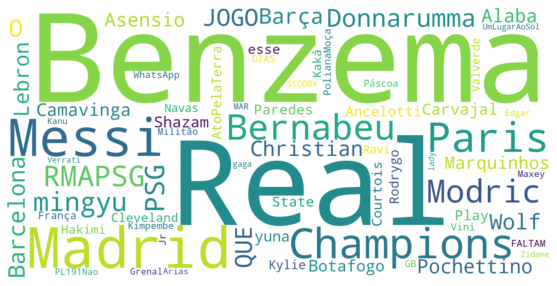

In [33]:
# Creating a WordCloud plot
wordcloud = WordCloud(width = 1600,
                      height = 800,
                      background_color = 'white',
                      collocations = False,
                      repeat = False).generate_from_text(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.savefig(f'wordcloud.png',
            dpi = 300)
plt.show()